### Imports

In [319]:
# Standard library
import sqlite3
import os

# Third-party
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Local application
from kickbase_api.player_data import (
    get_all_players,
    get_player_id,
    get_player_info,
    get_player_market_value,
    get_player_performance,
)
from kickbase_api.user_management import login

### Login to Kickbase

In [320]:
# Load environment variables from .env file
load_dotenv() 
USERNAME = os.getenv("KICK_USER")
PASSWORD = os.getenv("KICK_PASS")

# Login and get token
token = login(USERNAME, PASSWORD)
print("Logged in.")

Logged in.


### Connect to SQLite Database

In [ ]:
conn = sqlite3.connect("bundesliga.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS player_data_1d (
    player_id INTEGER,
    team_id INTEGER,
    team_name TEXT,
    first_name TEXT,
    last_name TEXT,
    position TEXT,
    md DATE,
    date DATE,
    p REAL,
    mp INTEGER,
    ppm REAL,
    t1 INTEGER,
    t2 INTEGER,
    t1g INTEGER,
    t2g INTEGER,
    won INTEGER,
    k TEXT,
    mv REAL
);
""")

conn.commit()

### Get Player Data from Kickbase and Store in Database

In [322]:
competition_ids = [1]  # 1 = Bundesliga, 2 = 2. Bundesliga (für mehr Training)
last_mv_values = 365  # in Tagen, max 365
last_pfm_values = 50  # in Spieltagen
reload_data = False

if reload_data:
    all_competitions_dfs = []

    for competition_id in competition_ids:
        players = get_all_players(token, competition_id)

        def process_player(player_id):
            player_info = get_player_info(token, competition_id, player_id)
            player_team_id = player_info["team_id"]
            player_df = pd.DataFrame([player_info])

            # Market Value
            mv_df = pd.DataFrame(get_player_market_value(token, competition_id, player_id, last_mv_values))
            if not mv_df.empty:
                mv_df["date"] = pd.to_datetime(mv_df["date"]).sort_values()

            # Performance
            p_df = pd.DataFrame(get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id))
            if not p_df.empty:
                p_df["date"] = pd.to_datetime(p_df["date"]).sort_values()
            else:
                p_df = pd.DataFrame({"date": pd.to_datetime([])})

            # Merge DataFrames
            merged_df = (
                pd.merge_asof(mv_df, p_df, on="date", direction="backward")
                if not mv_df.empty else pd.DataFrame()
            )

            if not merged_df.empty:
                merged_df = player_df.merge(merged_df, how="cross")
                merged_df["competition_id"] = competition_id

            return merged_df

        comp_dfs = list(map(process_player, players))
        comp_final_df = pd.concat(comp_dfs, ignore_index=True)
        all_competitions_dfs.append(comp_final_df)

    # Combine all competitions
    final_df = pd.concat(all_competitions_dfs, ignore_index=True)

    # Convert k column to string
    final_df["k"] = final_df["k"].apply(
        lambda x: ",".join(map(str, x)) if isinstance(x, list) else (None if x is None else str(x))
    )

    # Save to SQLite
    with sqlite3.connect("bundesliga.db") as conn:
        final_df.to_sql("player_data_1d", conn, if_exists="replace", index=False)


In [323]:
conn = sqlite3.connect("bundesliga.db")
df = pd.read_sql("SELECT * FROM player_data_1d", conn)
conn.close()

### Preprocess Data

In [ ]:
# 1. Sort and filter
df = df.sort_values(["player_id", "date"])
df = df[(df["team_id"] == df["t1"]) | (df["team_id"] == df["t2"])]  # keep only t1 or t2

# Convert date columns to datetime
df["date"] = pd.to_datetime(df["date"])
df["md"] = pd.to_datetime(df["md"])

# 2. Date and matchday calculations 
df["next_day"] = df.groupby("player_id")["date"].shift(-1) 
df["next_md"] = df.groupby("player_id")["md"].transform(
    lambda x: x.shift(-1).where(x.shift(-1) != x).bfill()
)
df["days_to_next"] = (df["next_md"] - df["date"]).dt.days

# 3. Next day market value
df["mv_next_day"] = df.groupby("player_id")["mv"].shift(-1)
df["mv_target"] = df["mv_next_day"] - df["mv"]
df = df[df["mv"] != 0.0]

# 4. Fill missing values
fill_values = {
    "p": 0,
    "ppm": 0,
    "won": -1
}
df = df.fillna(value=fill_values)  # assign back to df to avoid chained assignment

# 5. Drop rows with NaN in critical columns
df = df.dropna(subset=["mv_next_day", "mv_target", "next_md", "days_to_next"])

# 6. Feature engineering 
# Market value trend 1d
df["mv_change_1d"] = df["mv"] - df.groupby("player_id")["mv"].shift(1)
df["mv_trend_1d"] = df.groupby("player_id")["mv"].pct_change()
df["mv_trend_1d"] = df["mv_trend_1d"].replace([np.inf, -np.inf], 0).fillna(0)

# Market value trend 3d
df["mv_change_3d"] = df["mv"] - df.groupby("player_id")["mv"].shift(3)
df["mv_vol_3d"] = df.groupby("player_id")["mv"].rolling(3).std().reset_index(0,drop=True)

# Market value trend 7d
df["mv_trend_7d"] = df.groupby("player_id")["mv"].pct_change(periods=7)
df["mv_trend_7d"] = df["mv_trend_7d"].replace([np.inf, -np.inf], 0).fillna(0)

## League-wide market context
df["market_divergence"] = (df["mv"] / df.groupby("md")["mv"].transform("mean")).rolling(3).mean()

# 7. Clip outliers in mv_target
Q1 = df["mv_target"].quantile(0.25)
Q3 = df["mv_target"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

df["mv_target_clipped"] = df["mv_target"].clip(lower_bound, upper_bound)

,player_id,mv,mv_next_day,mv_target,date,md,next_md,days_to_next
159777,10003,500000.0,500000.0,0.0,2025-05-28,2025-05-18,2025-08-24,88.0
159778,10003,500000.0,500000.0,0.0,2025-05-29,2025-05-18,2025-08-24,87.0
159779,10003,500000.0,500000.0,0.0,2025-05-30,2025-05-18,2025-08-24,86.0
159780,10003,500000.0,500000.0,0.0,2025-05-31,2025-05-18,2025-08-24,85.0
159781,10003,500000.0,500000.0,0.0,2025-06-01,2025-05-18,2025-08-24,84.0
159782,10003,500000.0,500000.0,0.0,2025-06-02,2025-05-18,2025-08-24,83.0
159783,10003,500000.0,500000.0,0.0,2025-06-03,2025-05-18,2025-08-24,82.0
159784,10003,500000.0,500000.0,0.0,2025-06-04,2025-05-18,2025-08-24,81.0
159785,10003,500000.0,500000.0,0.0,2025-06-05,2025-05-18,2025-08-24,80.0
159786,10003,500000.0,548160.0,48160.0,2025-06-06,2025-05-18,2025-08-24,79.0


### Select Features and Target Variable

In [325]:
features = [
    "p", "mv", "days_to_next", 
    "mv_change_1d", "mv_trend_1d", 
    "mv_change_3d", "mv_vol_3d",
    "mv_trend_7d", "market_divergence"
]

# TODO Features: Fit or Injury and Starting Eleven Prediction

target = "mv_target_clipped" # or "mv_target"

# Split by time, to avoid data leakage
train = df[df["date"] < "2025-01-01"]
test = df[df["date"] >= "2025-01-01"]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Train Machine Learning Model

In [333]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
signs_correct = np.sum(np.sign(y_test) == np.sign(y_pred))

print(f"Sign accuracy: {np.round((signs_correct / len(y_test)) * 100, 2)}%")
print(f"RMSE: {np.round(rmse, 2)}")
print(f"MAE: {np.round(mae, 2)}")
print(f"R²: {np.round(r2, 3)}")

Sign accuracy: 65.75%
RMSE: 3039375725.35
MAE: 28192.29
R²: 0.799


### Example Player Prediction

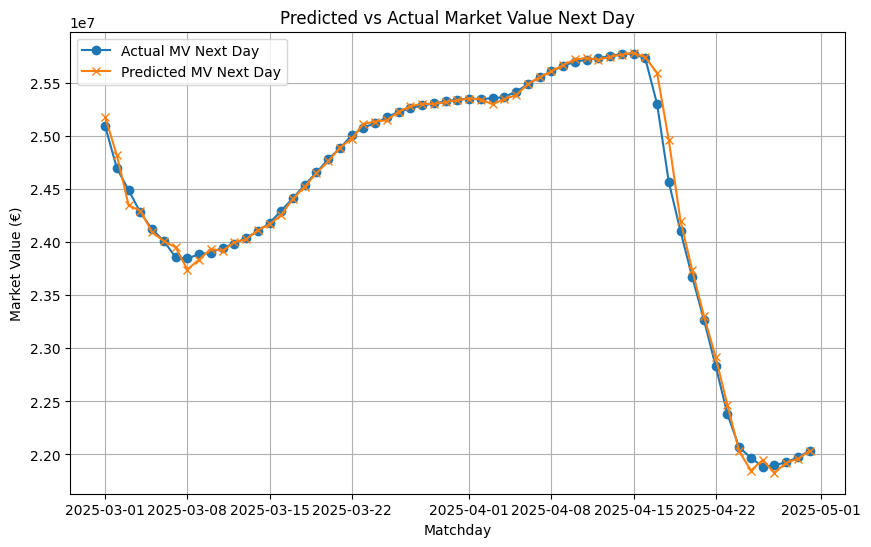

In [335]:
small_test = test[["player_id", "first_name", "last_name", "date", "mv", "mv_next_day", "mv_target"]].copy()

small_test["predicted_mv_target"] = np.round(y_pred, 2)
small_test["predicted_mv_next_day"] = small_test["mv"] + small_test["predicted_mv_target"]


# get error between prediction and actual 
small_test["error"] = small_test["mv_next_day"] - small_test["predicted_mv_next_day"]

# Sort by error ascending

small_test = small_test.sort_values("date")

small_test = small_test[(small_test["last_name"] == "Raum")]


# Filter small test only between 2025-03 and 2025-04
small_test = small_test[(small_test["date"] >= "2025-03-01") & (small_test["date"] <= "2025-04-30")]


# Plot predicted vs actual mv_next_week
plt.figure(figsize=(10, 6))
plt.plot(small_test["date"], small_test["mv_next_day"], marker='o', label="Actual MV Next Day")
plt.plot(small_test["date"], small_test["predicted_mv_next_day"], marker='x', label="Predicted MV Next Day")
plt.xlabel("Matchday")
plt.ylabel("Market Value (€)")
plt.title("Predicted vs Actual Market Value Next Day")
plt.legend()
plt.grid(True)


### Feature Importance

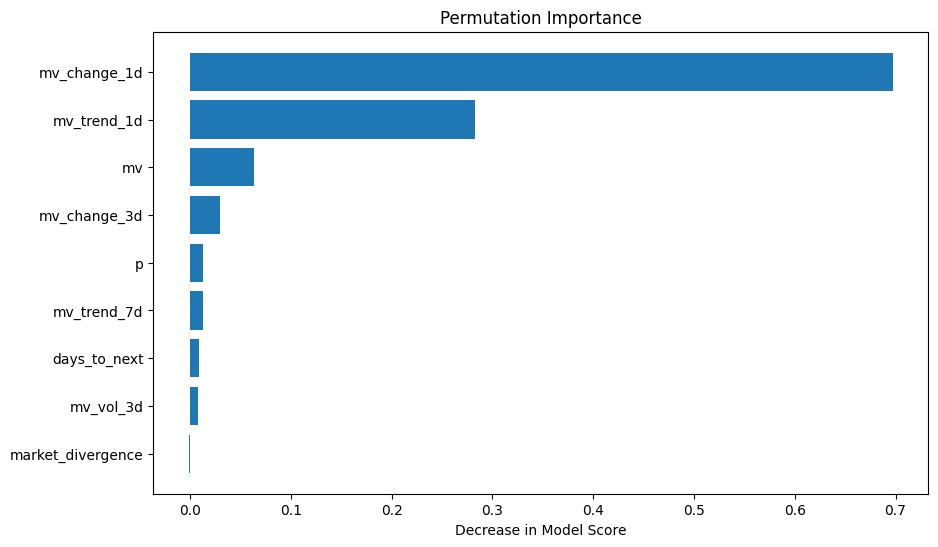

In [328]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'feature': features,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(perm_df['feature'], perm_df['importance'])
plt.gca().invert_yaxis()
plt.title("Permutation Importance")
plt.xlabel("Decrease in Model Score")
plt.show()

### Predicted vs Actual Values

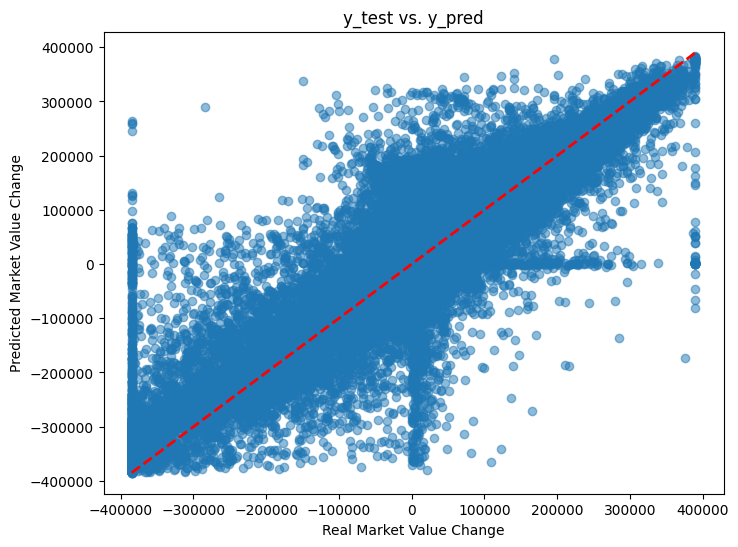

In [329]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel("Real Market Value Change")
plt.ylabel("Predicted Market Value Change")
plt.title("y_test vs. y_pred")
plt.show()

### Live Data Prediction

In [339]:
# Get all data with data after 18-08-2025
upcoming = df[df["date"] >= "2025-08-18"]

display(upcoming.head(10))

,player_id,team_id,team_name,first_name,last_name,position,mv,date,md_number,md,...,mv_trend_1d,mv_acceleration_1d,mv_change_3d,mv_trend_3d,mv_vol_3d,mv_change_7d,mv_trend_7d,mv_vol_7d,market_divergence,mv_target_clipped
159859,10003,28,Köln,Jusuf,Gazibegovic,2,3489623.0,2025-08-18,34.0,2025-05-18,...,0.057610,-0.004141,588325.0,0.202780,190992.217083,1668214.0,0.915892,489468.716299,0.858537,143098.0
159860,10003,28,Köln,Jusuf,Gazibegovic,2,3632721.0,2025-08-19,34.0,2025-05-18,...,0.041007,-0.016603,525081.0,0.168965,167142.781437,1506206.0,0.708298,444814.986064,0.904087,93291.0
159861,10003,28,Köln,Jusuf,Gazibegovic,2,3726012.0,2025-08-20,34.0,2025-05-18,...,0.025681,-0.015326,426474.0,0.129253,119065.813458,1317917.0,0.547286,393801.703754,0.941083,-55898.0
159862,10003,28,Köln,Jusuf,Gazibegovic,2,3670114.0,2025-08-21,34.0,2025-05-18,...,-0.015002,-0.040683,180491.0,0.051722,46950.387883,1016937.0,0.383290,312410.969786,0.956741,-185964.0
159863,10003,28,Köln,Jusuf,Gazibegovic,2,3484150.0,2025-08-22,34.0,2025-05-18,...,-0.050670,-0.035668,-148571.0,-0.040898,126625.710096,582852.0,0.200894,220213.156465,0.943852,-117910.0
159864,10003,28,Köln,Jusuf,Gazibegovic,2,3366240.0,2025-08-23,34.0,2025-05-18,...,-0.033842,0.016828,-359772.0,-0.096557,153201.819654,258600.0,0.083214,159174.741518,0.912642,-138753.0
16779,10006,39,St. Pauli,James,Sands,3,5963048.0,2025-08-18,34.0,2025-05-17,...,0.038606,-0.001691,676516.0,0.127970,222023.104440,1920433.0,0.475047,568956.726942,0.707011,231325.0
16780,10006,39,St. Pauli,James,Sands,3,6194373.0,2025-08-19,34.0,2025-05-17,...,0.038793,0.000188,675371.0,0.122372,226504.719874,1813620.0,0.413997,530644.685918,0.734734,190903.0
16781,10006,39,St. Pauli,James,Sands,3,6385276.0,2025-08-20,34.0,2025-05-17,...,0.030819,-0.007974,643878.0,0.112147,211436.237441,1690374.0,0.360045,493539.458296,0.761165,134320.0
16782,10006,39,St. Pauli,James,Sands,3,6519596.0,2025-08-21,34.0,2025-05-17,...,0.021036,-0.009783,556548.0,0.093333,163429.810387,1511298.0,0.301759,455159.231457,0.784011,-103120.0


### Testinggg

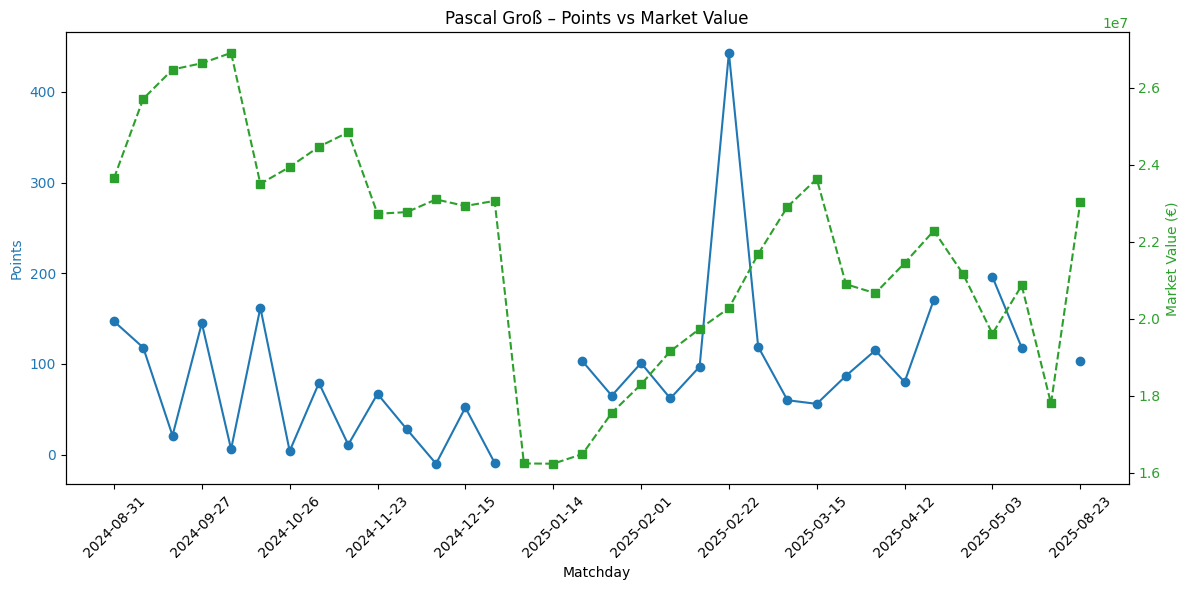

In [331]:
# we need competition_id, player_id, timeframe
competition_id = 1 # 1 is for Bundesliga, info from github issue thread
last_mv_values = 365 # in days, max 365
last_pfm_values = 50 # in matchdays
player_name = "Pascal Groß" # Example player

# Get player ID
player_id = get_player_id(token, competition_id, player_name)

# Get player info
player_info = get_player_info(token, competition_id, player_id)
player_team_id = player_info["team_id"]
player_df = pd.DataFrame([player_info])

# Get player market value
market_value = get_player_market_value(token, competition_id, player_id, last_mv_values)
mv_df = pd.DataFrame(market_value)

# Get player performance
performance = get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id)
p_df = pd.DataFrame(performance)

# Merge on 'date'
merged_df = pd.merge(p_df, mv_df, on="date", how="inner")
merged_df = player_df.merge(merged_df, how="cross")

#display(merged_df)

# Ensure correct column names (adjust if needed)
points_col = "p"          # from performance
mv_col = "mv"         # from market value
matchday_col = "date"            # common key

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Points (left y-axis)
color = "tab:blue"
ax1.set_xlabel("Matchday")
ax1.set_ylabel("Points", color=color)
ax1.plot(merged_df[matchday_col], merged_df[points_col], 
         marker="o", linestyle="-", color=color, label="Points")
ax1.tick_params(axis="y", labelcolor=color)

# X-axis formatting
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=15))  # max ~15 ticks
plt.xticks(rotation=45)

# Create second axis for Market Value (right y-axis)
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Market Value (€)", color=color)
ax2.plot(merged_df[matchday_col], merged_df[mv_col], 
         marker="s", linestyle="--", color=color, label="Market Value")
ax2.tick_params(axis="y", labelcolor=color)

# Title and layout
plt.title(f"{player_name} – Points vs Market Value")
fig.tight_layout()
plt.show()